In [1]:
%load_ext autoreload
%autoreload 2

import os, subprocess, urllib, tempfile, importlib

import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cortex as cx

from nilearn.surface import load_surf_data
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter, zoom

import popylar

/Users/knapen/software/miniconda3/envs/popylar/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


### Download data for demonstration

In [2]:
#
# download a pycortex subject (flatmap, etc) 
# of the 1.6 mm HCP standard surfaces from figshare
#

if not os.path.exists(os.path.join(cx.database.default_filestore, 'hcp_999999')):
    pycortex_sj_URL = "https://ndownloader.figshare.com/files/25768841"

    tempfolder = tempfile.gettempdir()
    urllib.request.urlretrieve(pycortex_sj_URL, os.path.join(tempfolder, 'hcp_999999.zip'))
    subprocess.run(['unzip', '-q', '-n', 
                    os.path.join(tempfolder, "hcp_999999.zip"), 
                    '-d', cx.database.default_filestore])

#
# and then download several projects' data from figshare
# and extract the prf experiment data
#
with importlib.resources.files(popylar) as package:
    prf_data_folder = package / 'data' / 'demo'  / 'prf_mapper_59k'
    atlas_folder = package / 'data' / 'demo' / 'atlas'
    if not os.path.exists(prf_data_folder):
        timeseries_data_URL = 'https://ndownloader.figshare.com/articles/14096209/versions/3'
        urllib.request.urlretrieve(timeseries_data_URL, os.path.join(tempfolder, '14096209.zip'))
        subprocess.run(['unzip', '-qq', '-n', 
                        os.path.join(tempfolder, '14096209.zip'), '-d', tempfolder])
        subprocess.run(['unzip', '-qq', '-n', 
                        os.path.join(tempfolder, 'prf_mapper_59k.zip'), '-d', 
                        prf_data_folder])                
        subprocess.run(['unzip', '-qq', '-n', 
                        os.path.join(tempfolder, 'atlas.zip'), '-d', 
                        os.path.split(atlas_folder)[0]])           


### Load data 

In [3]:
tseries_raw = np.nan_to_num(np.concatenate([load_surf_data(os.path.join(prf_data_folder, 
                                                f'sub-02_task-prf_space-59k_hemi-{hemi}_run-median_desc-bold.func.gii'))
                                for hemi in ['L', 'R']]))
atlas_data = np.concatenate([load_surf_data(
        os.path.join(atlas_folder, f'Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Colors.59k_fs_LR.dlabel.{hemi}.gii'))
         for hemi in ['L', 'R']])
atlas_data_both_hemis = np.mod(atlas_data, 180)

In [4]:
design_matrix = loadmat(os.path.join(prf_data_folder, 'vis_design.mat'))['stim'].T
sm_design_matrix = np.array([gaussian_filter(dmt, 8).T for dmt in design_matrix])
sm_design_matrix = np.array([zoom(smd, 1/3) for smd in sm_design_matrix])
sm_design_matrix = sm_design_matrix.transpose((2,1,0))

### Create necessary popylar objects

In [5]:
stim = popylar.stimuli.PRFStimulus2D(design_matrix=sm_design_matrix,
                     sample_rate=1/1.5,
                     screen_size_cm=60,
                     screen_distance_cm=210)

In [6]:
hrf = popylar.signal.HRF(sample_rate=stim.sample_rate,
                        hrf_type='spm')

filt = popylar.signal.DCT_Filter(n_timepoints=stim.n_timepoints,
                sample_rate=stim.sample_rate,
                highpass_freq= 250)

model = popylar.models.Iso2DGaussianModel(
    stimulus=stim,
    irf=hrf)

In [9]:
data_filt = popylar.signal.DCT_Filter(n_timepoints=stim.n_timepoints,
                sample_rate=stim.sample_rate,
                highpass_freq= 250, 
                highpass_add='mean')

tseries_filt0 = data_filt.filter(tseries_raw[0])
tseries_filt = data_filt.filter(tseries_raw)
tseries_psc = 100 * (tseries_filt-np.median(tseries_filt, -1)[:,np.newaxis])/np.median(tseries_filt, -1)[:,np.newaxis]



(120,) (118584, 120)


/var/folders/vr/m_p1yr2d687bgmqdsr5_x5qr0000gn/T/ipykernel_1293/1637942036.py:8: RuntimeWarning: divide by zero encountered in true_divide
  tseries_psc = 100 * (tseries_filt-np.median(tseries_filt, -1)[:,np.newaxis])/np.median(tseries_filt, -1)[:,np.newaxis]
/var/folders/vr/m_p1yr2d687bgmqdsr5_x5qr0000gn/T/ipykernel_1293/1637942036.py:8: RuntimeWarning: invalid value encountered in true_divide
  tseries_psc = 100 * (tseries_filt-np.median(tseries_filt, -1)[:,np.newaxis])/np.median(tseries_filt, -1)[:,np.newaxis]


In [ ]:
fitter = popylar.fitters.Iso2DGaussianFitter(data=tseries_filt,
                                             model=model)

### Start creating predictions and fitting them

In [ ]:
fitter.create_grid_predictions(x_grid=np.linspace(-10,10,20), 
                               y_grid=np.linspace(-10,10,20),
                               size_grid=np.linspace(0.5,4,20)**2)

In [ ]:
fitter.grid_fit()
# dm = np.array([np.ones(stim.n_timepoints), fitter.grid_predictions[0]], dtype=np.float32).T
# betas, rsq = popylar.fitters.fit_utils.fit_glm(data=tseries_raw, design_matrix=dm)

0it [00:00, ?it/s]/Users/knapen/projects/popylar/popylar/fitters/gauss_2D_iso.py:94: RuntimeWarning: invalid value encountered in greater
  super().grid_fit(regressor_df=regressor_df,
4767it [2:50:45,  1.65it/s]  

In [ ]:
regressor_df = pd.DataFrame(np.ones((fitter.grid_predictions.shape[-1], 2)),
                                        columns=['prf_baseline', 'prf_amplitude'])
fitter.collect_grid_results(columns=regressor_df.columns)

(array([1.18153e+05, 6.30000e+01, 7.00000e+01, 4.50000e+01, 3.20000e+01,
        2.90000e+01, 2.00000e+01, 3.00000e+01, 4.10000e+01, 1.01000e+02]),
 array([0.        , 0.09991583, 0.19983165, 0.29974748, 0.39966331,
        0.49957913, 0.59949496, 0.69941078, 0.79932661, 0.89924244,
        0.99915826]),
 <a list of 10 Patch objects>)

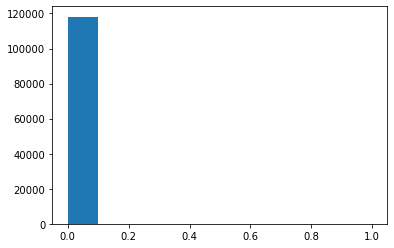

In [ ]:
plt.hist(fitter.grid_fit_results['grid_rsq'])
# fitter.grid_fit_results.shape, fitter.grid_xs.shape, fitter.best_fit_models.shape

In [ ]:
from popylar.rf import gauss2D_iso_cart
rf = gauss2D_iso_cart(x=stim.masked_coordinates[1],
                    y=stim.masked_coordinates[],
                    mu=[4, -1],
                    sigma=1.0)

SyntaxError: invalid syntax (3215722677.py, line 3)

In [ ]:
f, ss = plt.subplots(1,2,figsize=(20,7))
ss[0].imshow(rf.reshape(stim.y.T.shape))
ss[1].imshow(np.rot90(rf.reshape(stim.y.T.shape)))

In [ ]:
np.r_[np.ones((300,3)), np.ones((300))[:,np.newaxis]]